In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!pip install stardist
!pip install "numpy<2" --force-reinstall

  Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.0 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jax 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
pytensor 2.35.1 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0

In [1]:
import numpy as np
print(np.__version__)   # phải là 1.26.x
import stardist
stardist.__version__

1.26.4


'0.9.1'

In [2]:
!unzip /content/drive/MyDrive/IoT/BubbleImages_.zip -d /content/train

Archive:  /content/drive/MyDrive/IoT/BubbleImages_.zip
   creating: /content/train/frames/
  inflating: /content/train/frames/frame_0001.png  
  inflating: /content/train/frames/frame_0002.png  
  inflating: /content/train/frames/frame_0003.png  
  inflating: /content/train/frames/frame_0004.png  
  inflating: /content/train/frames/frame_0005.png  
  inflating: /content/train/frames/frame_0006.png  
  inflating: /content/train/frames/frame_0007.png  
  inflating: /content/train/frames/frame_0008.png  
  inflating: /content/train/frames/frame_0009.png  
  inflating: /content/train/frames/frame_0010.png  
  inflating: /content/train/frames/frame_0011.png  
  inflating: /content/train/frames/frame_0012.png  
  inflating: /content/train/frames/frame_0013.png  
  inflating: /content/train/frames/frame_0014.png  
  inflating: /content/train/frames/frame_0015.png  
  inflating: /content/train/frames/frame_0016.png  
  inflating: /content/train/frames/frame_0017.png  
  inflating: /content/tra

In [3]:
!unzip /content/drive/MyDrive/IoT/full_masks.zip -d /content/train/masks

Archive:  /content/drive/MyDrive/IoT/full_masks.zip
  inflating: /content/train/masks/frame_0558_mask.png  
  inflating: /content/train/masks/frame_0599_mask.png  
  inflating: /content/train/masks/frame_0057_mask.png  
  inflating: /content/train/masks/frame_0784_mask.png  
  inflating: /content/train/masks/frame_0247_mask.png  
  inflating: /content/train/masks/frame_0459_mask.png  
  inflating: /content/train/masks/frame_0170_mask.png  
  inflating: /content/train/masks/frame_0087_mask.png  
  inflating: /content/train/masks/frame_0846_mask.png  
  inflating: /content/train/masks/frame_0620_mask.png  
  inflating: /content/train/masks/frame_0560_mask.png  
  inflating: /content/train/masks/frame_0423_mask.png  
  inflating: /content/train/masks/frame_0039_mask.png  
  inflating: /content/train/masks/frame_0723_mask.png  
  inflating: /content/train/masks/frame_0098_mask.png  
  inflating: /content/train/masks/frame_0367_mask.png  
  inflating: /content/train/masks/frame_0382_mask.pn

In [4]:
import os
import numpy as np
from glob import glob
import imageio.v2 as imageio
from tqdm import tqdm
from csbdeep.utils import normalize

IMG_DIR = "/content/train/frames"
MASK_DIR = "/content/train/masks"

X, Y = [], []

img_files = sorted(glob(os.path.join(IMG_DIR, "frame_*.png")))

print("Found", len(img_files), "images")


for img_path in tqdm(img_files):

    fname = os.path.basename(img_path)
    mask_name = fname.replace(".png", "_mask.png")
    mask_path = os.path.join(MASK_DIR, mask_name)

    if not os.path.exists(mask_path):
        print("⚠ Missing mask:", mask_path)
        continue

    img_raw = imageio.imread(img_path)
    if img_raw.ndim == 3:
        img_raw = np.mean(img_raw[..., :3], axis=-1)

    img = normalize(img_raw, 1, 99.8).astype(np.float32)

    mask = imageio.imread(mask_path)
    mask = mask.astype(np.int32)

    X.append(img)
    Y.append(mask)


print("\nLoaded", len(X), "image-mask pairs")
if len(X) > 0:
    print("Example shapes:", X[0].shape, Y[0].shape)


Found 886 images


100%|██████████| 886/886 [00:20<00:00, 42.87it/s]


Loaded 886 image-mask pairs
Example shapes: (588, 428) (588, 428)


In [5]:
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(
    X, Y, test_size=0.2, random_state=42
)


In [ ]:
import numpy as np
from scipy.ndimage import zoom
import random

def random_fliprot(x, y):
    """
    Random flip + rotate 90°
    """
    k = random.randint(0,3)
    x = np.rot90(x, k)
    y = np.rot90(y, k)

    if random.random() < 0.5:
        x = np.fliplr(x)
        y = np.fliplr(y)
    if random.random() < 0.5:
        x = np.flipud(x)
        y = np.flipud(y)

    return x, y


def add_gaussian_noise(img, sigma=0.05):
    noise = np.random.normal(0, sigma, img.shape)
    return np.clip(img + noise, 0, 1)


def augmenter(x, y):
    """
    StarDist-compatible augmentation
    - Rotate + flip
    - Random zoom
    - Gaussian noise
    - Intensity jitter
    """

    # 🔁 Flip + rotate
    x, y = random_fliprot(x, y)

    # 🔍 Random zoom
    if random.random() < 0.5:
        scale = np.random.uniform(0.85, 1.15)

        x = zoom(x, scale, order=1)
        y = zoom(y, scale, order=0)

        # Force về 256x256
        H, W = x.shape

        if H > 256:
            x = x[:256, :256]
            y = y[:256, :256]
        else:
            pad_h = 256 - H
            pad_w = 256 - W

            x = np.pad(x, ((0,pad_h),(0,pad_w)), mode="reflect")
            y = np.pad(y, ((0,pad_h),(0,pad_w)), mode="constant")

    # 🌫 Gaussian noise
    x = add_gaussian_noise(x)

    # 🔆 Intensity jitter
    x = x * np.random.uniform(0.9,1.1)
    x = np.clip(x, 0, 1)

    return x, y

In [6]:

from stardist.models import Config2D, StarDist2D


config = Config2D(
    n_rays=64,
    grid=(2,2),
    train_patch_size=(256,256),

    # ✅ các param hợp lệ trong version mới
    train_epochs=200,
    train_steps_per_epoch=200,

    train_checkpoint="weights_best.weights.h5",
    train_checkpoint_epoch="weights_epoch.weights.h5",
    train_tensorboard=True
)


MODEL_DIR = "/content/drive/MyDrive/IoT/Lam_models"

model = StarDist2D(
    config=config,
    name="stardist_Lam_test",
    basedir=MODEL_DIR
)

print("Model & logs sẽ được lưu tại:")
print(model.logdir)


history = model.train(
    X_train,
    Y_train,
    validation_data=(X_val, Y_val),
    # augmenter=augmenter,

    epochs=200,
    steps_per_epoch=200
)

Using default values: prob_thresh=0.5, nms_thresh=0.4.
Model & logs sẽ được lưu tại:
/content/drive/MyDrive/IoT/Lam_models/stardist_Lam_test
Epoch 1/200
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - dist_dist_iou_metric: 0.1576 - dist_loss: 9.5374 - dist_relevant_mae: 9.5370 - dist_relevant_mse: 147.9918 - loss: 2.2911 - prob_kld: 0.2387 - prob_loss: 0.3836

base_model.py (78): Detected filename suffix '.weights.h5', thus saving in newer Keras 3.x file format (cannot be loaded with Keras 2.x)


200/200 ━━━━━━━━━━━━━━━━━━━━ 96s 355ms/step - dist_dist_iou_metric: 0.1584 - dist_loss: 9.5257 - dist_relevant_mae: 9.5252 - dist_relevant_mse: 147.7224 - loss: 2.2882 - prob_kld: 0.2382 - prob_loss: 0.3831 - val_dist_dist_iou_metric: 0.4979 - val_dist_loss: 4.6092 - val_dist_relevant_mae: 4.6087 - val_dist_relevant_mse: 41.7662 - val_loss: 1.1159 - val_prob_kld: 0.0470 - val_prob_loss: 0.1937 - learning_rate: 3.0000e-04
Epoch 2/200
200/200 ━━━━━━━━━━━━━━━━━━━━ 36s 178ms/step - dist_dist_iou_metric: 0.5550 - dist_loss: 3.7127 - dist_relevant_mae: 3.7121 - dist_relevant_mse: 31.2039 - loss: 0.9259 - prob_kld: 0.0368 - prob_loss: 0.1834 - val_dist_dist_iou_metric: 0.6420 - val_dist_loss: 2.8191 - val_dist_relevant_mae: 2.8176 - val_dist_relevant_mse: 20.9061 - val_loss: 0.7320 - val_prob_kld: 0.0214 - val_prob_loss: 0.1681 - learning_rate: 3.0000e-04
Epoch 3/200
200/200 ━━━━━━━━━━━━━━━━━━━━ 36s 180ms/step - dist_dist_iou_metric: 0.6561 - dist_loss: 2.6709 - dist_relevant_mae: 2.6704 - di

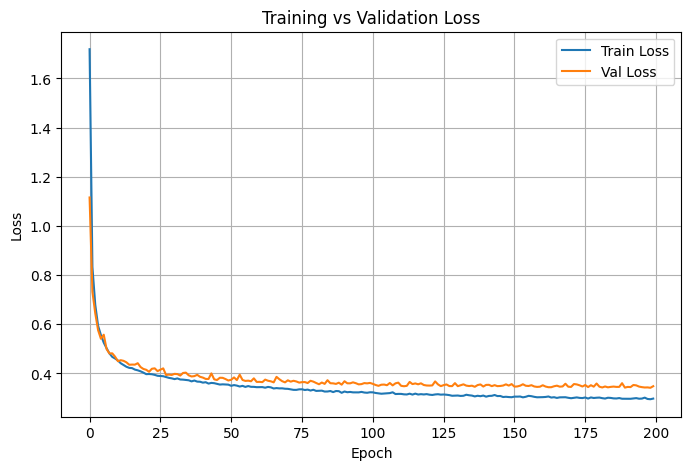

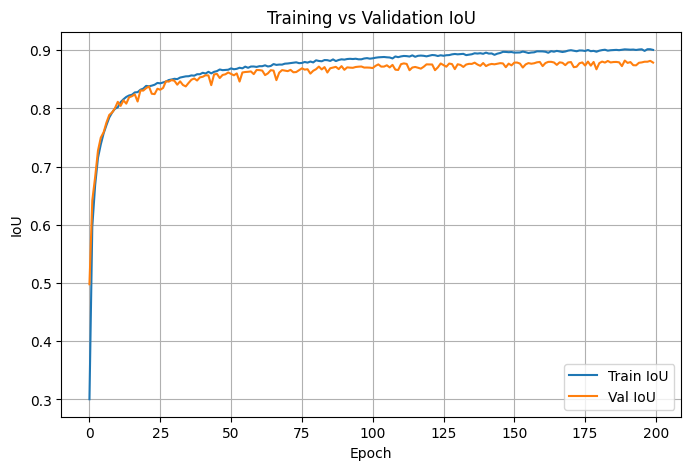

In [7]:
import matplotlib.pyplot as plt
import os

# === LOSS & VAL_LOSS ===
plt.figure(figsize=(8,5))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)

# Lưu vào cùng thư mục model (Lam_models/...)
# save_path_loss = os.path.join(model.logdir, "loss_curve.png")
# plt.savefig(save_path_loss, dpi=150, bbox_inches="tight")
# print("Đã lưu biểu đồ loss tại:", save_path_loss)

plt.show()


plt.figure(figsize=(8,5))
plt.plot(history.history["dist_dist_iou_metric"], label="Train IoU")
plt.plot(history.history["val_dist_dist_iou_metric"], label="Val IoU")
plt.xlabel("Epoch")
plt.ylabel("IoU")
plt.title("Training vs Validation IoU")
plt.legend()
plt.grid(True)

# save_path_iou = os.path.join(model.logdir, "iou_curve.png")
# plt.savefig(save_path_iou, dpi=150, bbox_inches="tight")
# print("Đã lưu biểu đồ IoU tại:", save_path_iou)

plt.show()


Số bubble dự đoán: 79


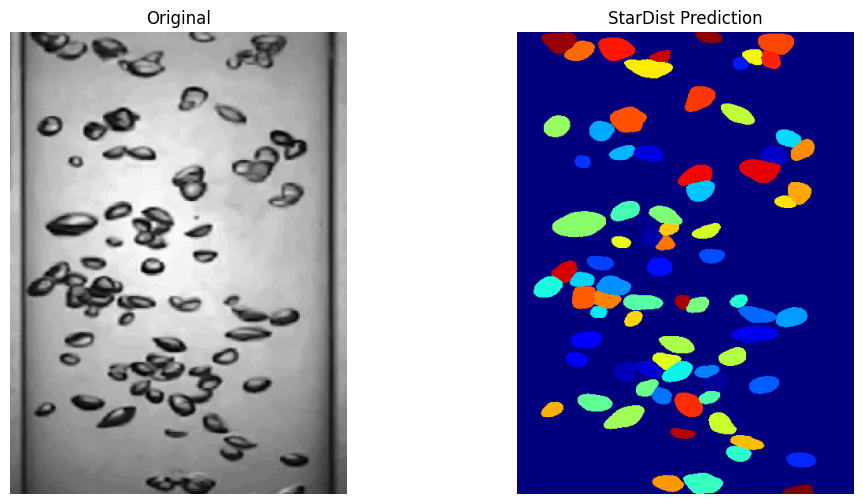

In [8]:
import imageio.v2 as imageio
import numpy as np
import matplotlib.pyplot as plt
from csbdeep.utils import normalize

# ----- LOAD IMAGE -----
img = imageio.imread("/content/train/frames/frame_0004.png")

# Nếu ảnh RGBA hoặc RGB → chuyển grayscale
if img.ndim == 3:
    img = img[..., :3]
    img = np.mean(img, axis=-1)

img_n = normalize(img, 1, 99.8)

# ----- PREDICT -----
labels, _ = model.predict_instances(img_n)

print("Số bubble dự đoán:", labels.max())

# ----- VẼ KẾT QUẢ -----
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.title("Original")
plt.imshow(img, cmap="gray")
plt.axis("off")

plt.subplot(1,2,2)
plt.title("StarDist Prediction")
plt.imshow(labels, cmap="jet")
plt.axis("off")

plt.show()

In [ ]:
from stardist.models import StarDist2D

model = StarDist2D(
    config=None,
    name="stardist_Lam_test",
    basedir="/content/drive/MyDrive/IoT/Lam_models"
)

print("Model loaded ✓")

Loading network weights from 'weights_best.h5'.
Couldn't load thresholds from 'thresholds.json', using default values. (Call 'optimize_thresholds' to change that.)
Using default values: prob_thresh=0.5, nms_thresh=0.4.
Model loaded ✓


In [9]:
import os
import glob
import imageio.v2 as imageio
import numpy as np
import pandas as pd
from csbdeep.utils import normalize
from skimage.measure import regionprops

# ======================================================
# B22DCCN476 - Đỗ Ngọc Lâm
# ======================================================

# ==============================
# CẤU HÌNH ĐƯỜNG DẪN
# ==============================
input_dir = "/content/train/frames"
output_dir = "/content/drive/MyDrive/IoT/Lam_models/result_stardist_Lam_test"

os.makedirs(output_dir, exist_ok=True)

# ----- LẤY DANH SÁCH ẢNH -----
image_paths = []
for ext in ("*.png", "*.jpg", "*.jpeg", "*.tif", "*.tiff"):
    image_paths.extend(glob.glob(os.path.join(input_dir, ext)))

image_paths = sorted(image_paths)

print(f"🔍 Tìm thấy {len(image_paths)} ảnh")

# List ghi dữ liệu CSV
records = []

# ==============================
# XỬ LÝ TỪNG ẢNH
# ==============================
for i, img_path in enumerate(image_paths):
    filename = os.path.basename(img_path)
    base_name = os.path.splitext(filename)[0]

    print(f"[{i+1}/{len(image_paths)}] 👉 {filename}")

    # ----- LOAD IMAGE -----
    img = imageio.imread(img_path)

    # RGB/RGBA → Grayscale
    if img.ndim == 3:
        img = img[..., :3]
        img = np.mean(img, axis=-1)

    img_n = normalize(img, 1, 99.8)

    # ----- PREDICT STAR DIST -----
    labels, _ = model.predict_instances(img_n)

    # ==============================
    # LƯU MASK LABEL (NHIỀU BUBBLE)
    # ==============================
    label_mask_name = f"{base_name}_label_mask.png"
    label_mask_path = os.path.join(output_dir, label_mask_name)

    imageio.imwrite(label_mask_path, labels.astype(np.uint16))

    # ==============================
    # TẠO & LƯU MASK ĐEN TRẮNG (BINARY)
    # ==============================
    # Bubble = 255 (trắng), Background = 0 (đen)
    binary_mask = np.zeros_like(labels, dtype=np.uint8)
    binary_mask[labels > 0] = 255

    binary_mask_name = f"{base_name}_binary_mask.png"
    binary_mask_path = os.path.join(output_dir, binary_mask_name)

    imageio.imwrite(binary_mask_path, binary_mask)

    # ==============================
    # PHÂN TÍCH TỪNG BUBBLE
    # ==============================
    props = regionprops(labels)

    for region in props:
        bubble_id = region.label
        area_px = region.area
        cy, cx = region.centroid   # (y, x)

        records.append({
            "filename": filename,
            "label_mask": label_mask_name,
            "binary_mask": binary_mask_name,
            "bubble_id": bubble_id,
            "area_px": area_px,
            "centroid_x": float(cx),
            "centroid_y": float(cy)
        })

# ==============================
# LƯU CSV
# ==============================
df = pd.DataFrame(records)

csv_path = os.path.join(output_dir, "bubble_measurements.csv")
df.to_csv(csv_path, index=False, encoding="utf-8-sig")

print("\n✅ HOÀN TẤT XỬ LÝ")
print(f"🖼 Label masks    → {output_dir}")
print(f"⬛ Binary masks   → {output_dir}")
print(f"📊 CSV kết quả    → {csv_path}")
print(f"🔢 Tổng bubble    → {len(df)}")


🔍 Tìm thấy 886 ảnh
[1/886] 👉 frame_0001.png
[2/886] 👉 frame_0002.png
[3/886] 👉 frame_0003.png
[4/886] 👉 frame_0004.png
[5/886] 👉 frame_0005.png
[6/886] 👉 frame_0006.png
[7/886] 👉 frame_0007.png
[8/886] 👉 frame_0008.png
[9/886] 👉 frame_0009.png
[10/886] 👉 frame_0010.png
[11/886] 👉 frame_0011.png
[12/886] 👉 frame_0012.png
[13/886] 👉 frame_0013.png
[14/886] 👉 frame_0014.png
[15/886] 👉 frame_0015.png
[16/886] 👉 frame_0016.png
[17/886] 👉 frame_0017.png
[18/886] 👉 frame_0018.png
[19/886] 👉 frame_0019.png
[20/886] 👉 frame_0020.png
[21/886] 👉 frame_0021.png
[22/886] 👉 frame_0022.png
[23/886] 👉 frame_0023.png
[24/886] 👉 frame_0024.png
[25/886] 👉 frame_0025.png
[26/886] 👉 frame_0026.png
[27/886] 👉 frame_0027.png
[28/886] 👉 frame_0028.png
[29/886] 👉 frame_0029.png
[30/886] 👉 frame_0030.png
[31/886] 👉 frame_0031.png
[32/886] 👉 frame_0032.png
[33/886] 👉 frame_0033.png
[34/886] 👉 frame_0034.png
[35/886] 👉 frame_0035.png
[36/886] 👉 frame_0036.png
[37/886] 👉 frame_0037.png
[38/886] 👉 frame_0038.png
[3